In [1]:
# Add project's path to system path
import os
import sys
try: 
    proj_path
except NameError:
    os.chdir('../')
    proj_path = os.getcwd()
    if proj_path not in sys.path:
        sys.path.append(proj_path)

# Import dependencies
import numpy as np
import matplotlib.pyplot as plt
import random
import networkx as nx
from scipy import linalg

from codebase import utils, rewiring, rewiring_iterations, directed_modularity # custom-made functions

# functions

In [2]:
def convert_from_adj2networkX(A,weight_d='binary'):

    edges_ind = np.where(A>0)
    num_edges = len(edges_ind[0])

    G = nx.DiGraph()   # DiGraph
    G.add_nodes_from(np.arange(A.shape[0]))

    edges_list = list()
    if weight_d == 'binary':
        for ind in np.arange(num_edges):
            edge_pair = (edges_ind[1][ind],edges_ind[0][ind])
            edges_list.append(edge_pair)
        
        G.add_edges_from(edges_list)    
    else:
        for ind in np.arange(num_edges):
            edge_pair_w = (edges_ind[1][ind],edges_ind[0][ind],A[edges_ind[0][ind],edges_ind[1][ind]])
            edges_list.append(edge_pair_w)    
        
        G.add_weighted_edges_from(edges_list)
        
        
    return G

In [3]:
def getDigraphPathMetricsForHubs(Ax,inOutThresh = 10):

    inDeg = np.sum(Ax,axis=1)
    outDeg = np.sum(Ax,axis=0)
    
    #thresh = inOutThresh
    #numHubs = len(np.where(inDeg>=thresh)[0]) + len(np.where(outDeg>=thresh)[0])
    #ttt = 'num of hubs are '+str(numHubs)
    #print(ttt)
    
    #numHubs2 = len(np.union1d(np.where(inDeg>=thresh)[0],np.where(outDeg>=thresh)[0]))
    #ttt = 'num of hubs2 are '+str(numHubs2)
    #print(ttt)
    
    #bare minimum nodes should have greater than 1 in and out-degrees
    nonZeroIn = np.where(inDeg>1)[0]
    nonZeroOut = np.where(outDeg>1)[0]
    nonZeroInOut = np.intersect1d(nonZeroIn,nonZeroOut)

    inOutDeg = inDeg + outDeg
    indNodesTemp = np.where(inOutDeg>=inOutThresh)[0]
    indNodes2Use = np.intersect1d(nonZeroInOut,indNodesTemp)
    lenNodes2Use = len(indNodes2Use)
    
    
    G = convert_from_adj2networkX(Ax)

    paths = dict(nx.all_pairs_dijkstra_path(G))
    len_paths = dict(nx.all_pairs_dijkstra_path_length(G))


    # it is opposite from the adjacency matrix, i.e. pathsMatrix[i,j] is path length from i to j
    pathsMatrix = np.zeros((lenNodes2Use,lenNodes2Use)) 
    for indSource,source in enumerate(indNodes2Use):
        for target in len_paths[source].keys():
            if target in indNodes2Use:
            
                indTarget = np.where(indNodes2Use == target)[0][0]
                pathsMatrix[indSource, indTarget] = len_paths[source][target]

    numPaths = np.sum(pathsMatrix>0)
    numNonPaths = lenNodes2Use*(lenNodes2Use-1) -numPaths 
    distPaths = pathsMatrix[np.where(pathsMatrix>0)]
    
    return indNodes2Use, numPaths,numNonPaths,distPaths,pathsMatrix

In [214]:
def getDigraphPathMetricsInOutConvDivUnit(Ax,inOutThresh):


    inDeg = np.sum(Ax,axis=1)
    outDeg = np.sum(Ax,axis=0)

    nonZeroIn = np.where(inDeg>1)[0]
    nonZeroOut = np.where(outDeg>1)[0]
    nonZeroInOut = np.intersect1d(nonZeroIn,nonZeroOut)

    inOutDeg = inDeg + outDeg
    indNodesTemp = np.where(inOutDeg>=inOutThresh)[0]
    indNodesUnit = np.intersect1d(nonZeroInOut,indNodesTemp)
    lenNodesUnit = len(indNodesUnit)

    indAllNodes = np.arange(100)
    #the nodes outside the convergent-divergent unit
    indNodesOut = np.setdiff1d(indAllNodes, indNodesUnit, assume_unique=False)


    #measure path lengths 
    G = convert_from_adj2networkX(Ax)
    paths = dict(nx.all_pairs_dijkstra_path(G))
    len_paths = dict(nx.all_pairs_dijkstra_path_length(G))


    #set up the matrix that will indicate the path from the out nodes to the unit and from the unit to the nodes
    nodes2unit = np.zeros((len(indNodesOut),len(indNodesUnit)))
    unit2nodes = np.zeros((len(indNodesUnit),len(indNodesOut)))

    #set up the matrix that will indicate the path from the out nodes to the unit 
    #it is opposite from the adjacency matrix, i.e. nodes2unit[i,j] is path length from i to j
    nodes2unit = np.zeros((len(indNodesOut),len(indNodesUnit)))
    for indSource,source in enumerate(indNodesOut):
        for indTarget,target in enumerate(indNodesUnit):
            if target in len_paths[source].keys():
                #tt = 'indTarget is '+str(indTarget)+' and indSource is '+str(indSource)
                #print(tt)
            
                nodes2unit[indSource, indTarget] = len_paths[source][target]

            
    #set up the matrix that will indicate the path from the unit to the out nodes 
    unit2nodes = np.zeros((len(indNodesUnit),len(indNodesOut)))
    for indSource,source in enumerate(indNodesUnit):
        for indTarget,target in enumerate(indNodesOut):
            if target in len_paths[source].keys():
                #tt = 'indTarget is '+str(indTarget)+' and indSource is '+str(indSource)
                #print(tt)
            
                unit2nodes[indSource, indTarget] = len_paths[source][target]            


    numPathsIn = np.sum(nodes2unit>0)
    numPathsOut = np.sum(unit2nodes>0)

    numNonPathsIn = nodes2unit.shape[0]*nodes2unit.shape[1] -numPathsIn 
    numNonPathsOut = unit2nodes.shape[0]*unit2nodes.shape[1] -numPathsOut 

    distPathsIn = nodes2unit[np.where(nodes2unit>0)]
    distPathsOut = unit2nodes[np.where(unit2nodes>0)]
    
    #at least one of the nodes in the unit sending to node out
    Out = np.sum(unit2nodes,axis=0)
    
    #the node out sending to at least one of the nodes in the unit
    In = np.sum(nodes2unit,axis=1)
    
    return indNodesUnit,indNodesOut,numPathsIn,numPathsOut,numNonPathsIn,numNonPathsOut,distPathsIn,distPathsOut,In,Out



In [156]:
directory_load = 'data/'

flag = '_cons_adv_50_'

file_path_load = directory_load +'A'+flag+'pRand.pckl'
A = utils.load_var(file_path_load)

pRandVec = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8, 1]
repetitions = 100

#Ax = A[4][0.2,1][4000]

## in order to produce all the panels at once we need to run a for loop with the variable inOutThresh changing. 

## In general, i think for this i do not save the intermediate values. So do the for loop and save the intermediate values....

In [243]:
inOutThresh = 15  #20, 25, 30

inOutDict = {}
for rep in np.arange(repetitions):
    for indP,p in enumerate(pRandVec):
        
        Ax = A[rep+1][p,1][4000]
        indNodesUnit,indNodesOut,numPathsIn,numPathsOut,numNonPathsIn,numNonPathsOut,distPathsIn,distPathsOut,In,Out = getDigraphPathMetricsInOutConvDivUnit(Ax,inOutThresh)

        inOutDict[rep+1,p,flag] = (indNodesUnit,indNodesOut,numPathsIn,numPathsOut,numNonPathsIn,numNonPathsOut,distPathsIn,distPathsOut,In,Out)


In [244]:
pR=[0,0.2,0.4,0.6]

numConnectOut= {}; numNoConnectOut = {};numConnectIn= {}; numNoConnectIn = {}

nodesAverage = {}
for p in pR:
    numConnectOut[p]= np.zeros((repetitions,1)); numNoConnectOut[p] = np.zeros((repetitions,1));
    numConnectIn[p]= np.zeros((repetitions,1)); numNoConnectIn[p] = np.zeros((repetitions,1));
    nodesAverage[p] = np.zeros((repetitions,1))
    for rep in np.arange(repetitions):
    
        (indNodesUnit,indNodesOut,numPathsIn,numPathsOut,numNonPathsIn,numNonPathsOut,distPathsIn,distPathsOut,In,Out)=inOutDict[rep+1,p,flag]
        
        numConnectOut[p][rep] = len(np.where(Out>0)[0])
        numNoConnectOut[p][rep] = (len(Out) - len(np.where(Out>0)[0]))
        
        numConnectIn[p][rep]= len(np.where(In>0)[0])
        numNoConnectIn[p][rep]= (len(In) - len(np.where(In>0)[0]))
    
        #tts = 'For p = '+str(p)+' and iteration = '+str(rep)+' we have '+str(len(indNodesUnit))+' in the unit'
        print(tts)
        nodesAverage[p][rep]= len(indNodesUnit)
        
    ttl = 'For p = '+str(p)+' the average number of nodes in the unit are '+str(np.mean(nodesAverage[p]))
    print(ttl)
percentIn = {}; percentOut = {}
for p in pR:
    
    percentIn[p] = numConnectIn[p]/(numConnectIn[p]+numNoConnectIn[p])
    percentOut[p] = numConnectOut[p]/(numConnectOut[p]+numNoConnectOut[p])
    

For p = 0.6 and iteration = 99 we have 9 in the unit
For p = 0.6 and iteration = 99 we have 9 in the unit
For p = 0.6 and iteration = 99 we have 9 in the unit
For p = 0.6 and iteration = 99 we have 9 in the unit
For p = 0.6 and iteration = 99 we have 9 in the unit
For p = 0.6 and iteration = 99 we have 9 in the unit
For p = 0.6 and iteration = 99 we have 9 in the unit
For p = 0.6 and iteration = 99 we have 9 in the unit
For p = 0.6 and iteration = 99 we have 9 in the unit
For p = 0.6 and iteration = 99 we have 9 in the unit
For p = 0.6 and iteration = 99 we have 9 in the unit
For p = 0.6 and iteration = 99 we have 9 in the unit
For p = 0.6 and iteration = 99 we have 9 in the unit
For p = 0.6 and iteration = 99 we have 9 in the unit
For p = 0.6 and iteration = 99 we have 9 in the unit
For p = 0.6 and iteration = 99 we have 9 in the unit
For p = 0.6 and iteration = 99 we have 9 in the unit
For p = 0.6 and iteration = 99 we have 9 in the unit
For p = 0.6 and iteration = 99 we have 9 in th

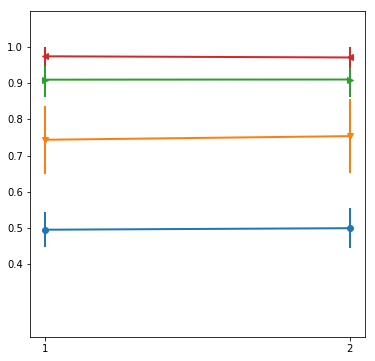

In [245]:
plt.rcParams['figure.figsize'] = [6, 6]  

meanIn={};stdIn={};
meanOut={};stdOut={};
markers = ['o','v','>','<','8','s']
for ind,p in enumerate(pR):
    meanIn[p] = np.mean(percentIn[p])
    stdIn[p] = np.std(percentIn[p])
    
    meanOut[p] = np.mean(percentOut[p])
    stdOut[p] = np.std(percentOut[p])  
    
    labelT = 'p = '+str(p)
    plt.ylim([0.2,1.1])    
    plt.errorbar([1,2],[meanIn[p],meanOut[p]],[stdIn[p],stdOut[p]],marker = markers[ind],label= labelT,linewidth=2)
    plt.xticks([1,2])
    plt.yticks([0.4,0.5,0.6,0.7,0.8,0.9,1.0])
#plt.legend()
    
filePathPlot = 'data/convdiv/percentInOutThresh'+str(inOutThresh)+'.eps'    

#plt.savefig(filePathPlot, format='eps', dpi=1200)    

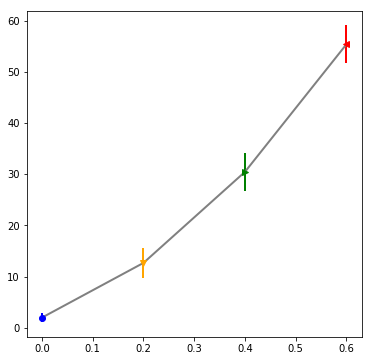

In [246]:


nodesMean = np.zeros((len(nodesAverage),1))
nodesStd = np.zeros((len(nodesAverage),1))
markers = ['o','v','>','<','8','s']
colors = ['blue','orange','green','red']
for ind,p in enumerate(pR):
    nodesMean[ind] = np.mean(nodesAverage[p])
    nodesStd[ind] = np.std(nodesAverage[p])
    
    
    

plt.errorbar(pR,nodesMean,color='grey',linewidth=2)

for ind in np.arange(len(nodesMean)):
    plt.errorbar(pR[ind],nodesMean[ind],nodesStd[ind],marker= markers[ind],color=colors[ind],linewidth=2)


filePathPlot = 'data/convdiv/NumNodesInUnit'+str(inOutThresh)+'.eps'    

plt.savefig(filePathPlot, format='eps', dpi=1200)    



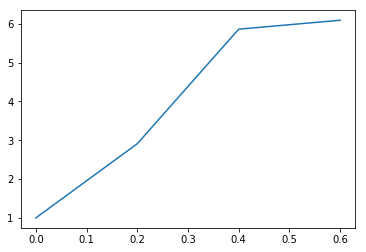

In [171]:
nodesAverageAll = np.zeros((len(nodesAverage),1))
for ind,p in enumerate(pR):
    nodesAverageAll[ind] = nodesAverage[p]
    
plt.plot(pR,nodesAverageAll)




## Misc

In [ ]:
degOutTT = {} 
for thre in thresh:
    degOutTest = []
    for dd in np.arange(1,100):
        if len(invPathDict[p,thre,dd]) != 0:
            degOutTest.append(dd)
    degOutTT[p,thre] = degOutTest    
    meanInvPath[p,thre] = np.zeros(len(degOutTest))
    stdInvPath[p,thre] = np.zeros(len(degOutTest))
    for ind,d in enumerate(degOutTest):
    
        meanInvPath[p,thre][ind] = np.mean(invPathDict[p,thre,d])
        stdInvPath[p,thre][ind] = np.std(invPathDict[p,thre,d])
    
plt.rcParams['figure.figsize'] = [6, 6]    
#plt.errorbar(degOutTest[0:15],1/meanInvPath[0:15],stdInvPath[0:15])
for thre in thresh:
    labelT = str(thre) 
    #plt.errorbar(degOutTT[p,thre][0:69],1/meanInvPath[p,thre][0:69],stdInvPath[p,thre][0:69],label= labelT)
    plt.errorbar(degOutTT[p,thre][0:20],1/meanInvPath[p,thre][0:20],stdInvPath[p,thre][0:20],label= labelT)
    plt.ylim((0.8, 3.8)) 
    #plt.legend()
    
filePathPlot = 'data/syncfire/pathlengthSmallp0.eps'    

plt.savefig(filePathPlot, format='eps', dpi=1200) 

In [22]:
#from nodes to unit


allNumPathsIn = 0; allNumNonPathsIn = 0;allDistPathsIn = []
allNumPathsOut = 0; allNumNonPathsOut = 0;allDistPathsOut = []

numConnectOut= 0; numNoConnectOut = 0;numConnectIn= 0; numNoConnectIn = 0

nodesAverage = 0
for rep in np.arange(repetitions):
    
    (indNodesUnit,indNodesOut,numPathsIn,numPathsOut,numNonPathsIn,numNonPathsOut,distPathsIn,distPathsOut,In,Out)=inOutDict[rep+1,p,flag]
    
    #from nodes to unit
    allNumPathsIn +=numPathsIn
    allNumNonPathsIn +=numNonPathsIn
    for kk in np.arange(len(distPathsIn)):
        allDistPathsIn.append(distPathsIn[kk])
    
    #from unit to nodes
    allNumPathsOut +=numPathsOut
    allNumNonPathsOut +=numNonPathsOut
    for kk in np.arange(len(distPathsOut)):
        allDistPathsOut.append(distPathsOut[kk])
        
        
    numConnectOut += len(np.where(Out>0)[0])
    numNoConnectOut += (len(Out) - len(np.where(Out>0)[0]))
        
    numConnectIn += len(np.where(In>0)[0])
    numNoConnectIn += (len(In) - len(np.where(In>0)[0]))
    
    nodesAverage =nodesAverage +len(indNodesUnit)
    
nodesAverage = nodesAverage/repetitions

array([ 1,  2,  3,  4,  5,  6,  7,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
       36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52,
       53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69,
       70, 71, 72, 73, 74, 75, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87,
       88, 89, 90, 92, 93, 94, 95, 96, 97, 98, 99])